In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

# Redoing model selection with validation set

In [6]:
df = pd.read_excel("BaseFeaturesDE.xlsx")
df = df.drop('Unnamed: 0', axis = 1)
df

,From Timestamp,DE Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,2018-05-10 09:30:00,332.0,3,9.5,0,5,12.0,12.0,61.88
1,2018-05-10 10:00:00,332.0,3,10.0,0,5,12.8,12.8,58.50
2,2018-05-10 10:30:00,334.0,3,10.5,0,5,12.8,12.8,58.50
3,2018-05-10 11:00:00,334.0,3,11.0,0,5,13.3,13.3,55.36
4,2018-05-10 11:30:00,337.0,3,11.5,0,5,13.3,13.3,55.36
...,...,...,...,...,...,...,...,...,...
28824,2019-12-31 21:30:00,227.0,1,21.5,0,12,6.5,3.3,88.23
28825,2019-12-31 22:00:00,227.0,1,22.0,0,12,6.6,4.4,87.69
28826,2019-12-31 22:30:00,226.0,1,22.5,0,12,6.6,4.4,87.69
28827,2019-12-31 23:00:00,228.0,1,23.0,0,12,6.7,4.1,88.13


# First by splitting it according to time
The splitting will be 60:20:20


In [26]:
df = pd.read_excel("BaseFeaturesDE.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['DE Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.15)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*15/85)

Xtrain = Xinput.iloc[:size2].copy() #70%
Xvalidate = Xinput.iloc[size2:].copy() #15%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['DE Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['DE Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['DE Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['DE Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)



In [8]:
print(len(trainXscaled))
print(len(validateXscaled))
print(len(testXscaled))
print(len(inputXscaled))

19913
4266
4266
24179


# Random Forest Regressor

In [10]:
N = range(10,1011,100)

RFR = GridSearchCV(RandomForestRegressor(random_state=42, max_depth=5), {
    'n_estimators': N
}, cv=5, return_train_score=False)
RFR.fit(trainXscaled, trainy)

RFR_results = pd.DataFrame(RFR.cv_results_)
RFR_results = RFR_results[['param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
RFR_results

,param_n_estimators,mean_test_score,rank_test_score
10,1010,0.701439,1
9,910,0.701251,2
7,710,0.700941,3
8,810,0.700900,4
6,610,0.700090,5
5,510,0.700047,6
2,210,0.699306,7
4,410,0.699251,8
3,310,0.698869,9
1,110,0.698178,10


In [11]:
N = range(5,96,10)

RFR1 = GridSearchCV(RandomForestRegressor(random_state=42, max_depth=5), {
    'n_estimators': N
}, cv=5, return_train_score=False)
RFR1.fit(trainXscaled, trainy)

RFRresults1 = pd.DataFrame(RFR1.cv_results_)
RFRresults1 = RFRresults1[['param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
RFRresults1



,param_n_estimators,mean_test_score,rank_test_score
5,55,0.701876,1
6,65,0.699925,2
8,85,0.699025,3
7,75,0.698641,4
3,35,0.698641,5
4,45,0.698532,6
9,95,0.698181,7
2,25,0.697016,8
1,15,0.690722,9
0,5,0.661699,10


In [12]:
RFRresults2 = RFR_results.copy()
RFRresults = RFRresults2.append(RFRresults1)
RFRresults = RFRresults.sort_values(by=['mean_test_score'])
RFRresults


,param_n_estimators,mean_test_score,rank_test_score
0,5,0.661699,10
0,10,0.680081,11
1,15,0.690722,9
2,25,0.697016,8
1,110,0.698178,10
9,95,0.698181,7
4,45,0.698532,6
3,35,0.698641,5
7,75,0.698641,4
3,310,0.698869,9


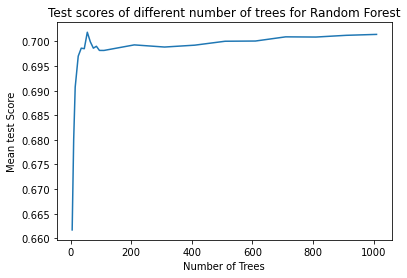

In [13]:
RFRresults = RFRresults.sort_values(by=['param_n_estimators'])
plt.plot(RFRresults['param_n_estimators'], RFRresults['mean_test_score'])

plt.xlabel('Number of Trees')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores of different number of trees for Random Forest')
# Display a figure.
plt.show()

7.659883718547117


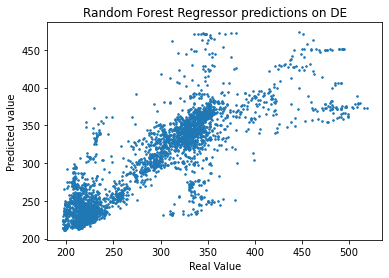

In [35]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42, max_depth=5).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

RandomForestMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions on DE')
# Display a figure.
plt.show()

18.057540332752634


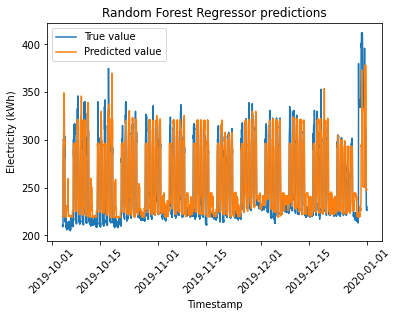

In [28]:
pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(validatey, pred) * 100
print(RandomForestMAPE)

plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

# Visualization examples

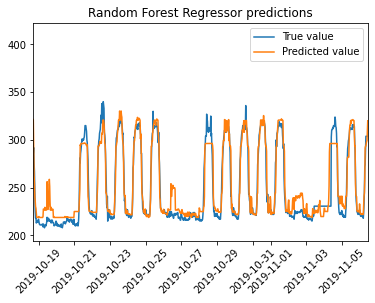

In [29]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+700], df['From Timestamp'].iloc[size+1600])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

#### What the hell is going on here?

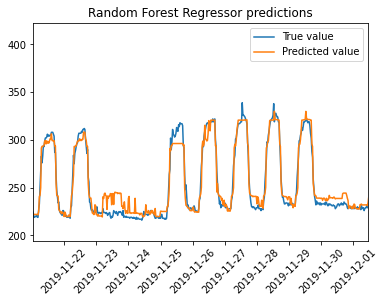

In [30]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+2300], df['From Timestamp'].iloc[size+2800])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()


# Another still existant outlier found at the exact same spot as for HH.

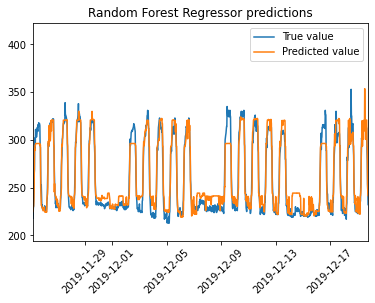

In [34]:
plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+2500], df['From Timestamp'].iloc[size+3680])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

In [ ]:
error = 100*(pred - testy)/testy
plt.hist(error, bins=100)
plt.title('Distribution of Random Forest Regressor prediction errors')
plt.xlabel('Prediction Error in %')
_ = plt.ylabel('Count')

# KNN


In [19]:
N = range(1,150,1)

KNN = GridSearchCV(KNeighborsRegressor(), {
    'n_neighbors': N,
    'weights': ['uniform', 'distance']
}, cv=5, return_train_score=False, verbose = 3)
KNN.fit(inputXscaled, inputy)
KNN_results = pd.DataFrame(KNN.cv_results_)
KNN_results = KNN_results[['param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
KNN_results

Fitting 5 folds for each of 298 candidates, totalling 1490 fits
[CV 1/5] END .................n_neighbors=1, weights=uniform; total time=   0.7s
[CV 2/5] END .................n_neighbors=1, weights=uniform; total time=   0.7s
[CV 3/5] END .................n_neighbors=1, weights=uniform; total time=   0.7s
[CV 4/5] END .................n_neighbors=1, weights=uniform; total time=   1.0s
[CV 5/5] END .................n_neighbors=1, weights=uniform; total time=   0.8s
[CV 1/5] END ................n_neighbors=1, weights=distance; total time=   0.7s
[CV 2/5] END ................n_neighbors=1, weights=distance; total time=   0.7s
[CV 3/5] END ................n_neighbors=1, weights=distance; total time=   0.8s
[CV 4/5] END ................n_neighbors=1, weights=distance; total time=   1.0s
[CV 5/5] END ................n_neighbors=1, weights=distance; total time=   0.9s
[CV 1/5] END .................n_neighbors=2, weights=uniform; total time=   0.8s
[CV 2/5] END .................n_neighbors=2, 

[CV 2/5] END ................n_neighbors=11, weights=uniform; total time=   0.8s
[CV 3/5] END ................n_neighbors=11, weights=uniform; total time=   1.3s
[CV 4/5] END ................n_neighbors=11, weights=uniform; total time=   1.7s
[CV 5/5] END ................n_neighbors=11, weights=uniform; total time=   1.0s
[CV 1/5] END ...............n_neighbors=11, weights=distance; total time=   0.8s
[CV 2/5] END ...............n_neighbors=11, weights=distance; total time=   0.8s
[CV 3/5] END ...............n_neighbors=11, weights=distance; total time=   1.0s
[CV 4/5] END ...............n_neighbors=11, weights=distance; total time=   1.3s
[CV 5/5] END ...............n_neighbors=11, weights=distance; total time=   1.0s
[CV 1/5] END ................n_neighbors=12, weights=uniform; total time=   0.9s
[CV 2/5] END ................n_neighbors=12, weights=uniform; total time=   1.0s
[CV 3/5] END ................n_neighbors=12, weights=uniform; total time=   1.1s
[CV 4/5] END ...............

[CV 4/5] END ................n_neighbors=21, weights=uniform; total time=   1.4s
[CV 5/5] END ................n_neighbors=21, weights=uniform; total time=   1.1s
[CV 1/5] END ...............n_neighbors=21, weights=distance; total time=   0.9s
[CV 2/5] END ...............n_neighbors=21, weights=distance; total time=   0.9s
[CV 3/5] END ...............n_neighbors=21, weights=distance; total time=   1.1s
[CV 4/5] END ...............n_neighbors=21, weights=distance; total time=   1.4s
[CV 5/5] END ...............n_neighbors=21, weights=distance; total time=   1.1s
[CV 1/5] END ................n_neighbors=22, weights=uniform; total time=   1.0s
[CV 2/5] END ................n_neighbors=22, weights=uniform; total time=   1.0s
[CV 3/5] END ................n_neighbors=22, weights=uniform; total time=   1.3s
[CV 4/5] END ................n_neighbors=22, weights=uniform; total time=   1.5s
[CV 5/5] END ................n_neighbors=22, weights=uniform; total time=   1.1s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=31, weights=distance; total time=   1.0s
[CV 2/5] END ...............n_neighbors=31, weights=distance; total time=   1.0s
[CV 3/5] END ...............n_neighbors=31, weights=distance; total time=   1.6s
[CV 4/5] END ...............n_neighbors=31, weights=distance; total time=   1.7s
[CV 5/5] END ...............n_neighbors=31, weights=distance; total time=   1.2s
[CV 1/5] END ................n_neighbors=32, weights=uniform; total time=   1.0s
[CV 2/5] END ................n_neighbors=32, weights=uniform; total time=   1.1s
[CV 3/5] END ................n_neighbors=32, weights=uniform; total time=   1.2s
[CV 4/5] END ................n_neighbors=32, weights=uniform; total time=   1.5s
[CV 5/5] END ................n_neighbors=32, weights=uniform; total time=   1.2s
[CV 1/5] END ...............n_neighbors=32, weights=distance; total time=   1.0s
[CV 2/5] END ...............n_neighbors=32, weights=distance; total time=   1.1s
[CV 3/5] END ...............

[CV 3/5] END ...............n_neighbors=41, weights=distance; total time=   1.6s
[CV 4/5] END ...............n_neighbors=41, weights=distance; total time=   2.0s
[CV 5/5] END ...............n_neighbors=41, weights=distance; total time=   1.3s
[CV 1/5] END ................n_neighbors=42, weights=uniform; total time=   1.1s
[CV 2/5] END ................n_neighbors=42, weights=uniform; total time=   1.1s
[CV 3/5] END ................n_neighbors=42, weights=uniform; total time=   1.3s
[CV 4/5] END ................n_neighbors=42, weights=uniform; total time=   1.6s
[CV 5/5] END ................n_neighbors=42, weights=uniform; total time=   1.2s
[CV 1/5] END ...............n_neighbors=42, weights=distance; total time=   1.1s
[CV 2/5] END ...............n_neighbors=42, weights=distance; total time=   1.1s
[CV 3/5] END ...............n_neighbors=42, weights=distance; total time=   1.3s
[CV 4/5] END ...............n_neighbors=42, weights=distance; total time=   1.7s
[CV 5/5] END ...............

[CV 5/5] END ...............n_neighbors=51, weights=distance; total time=   1.3s
[CV 1/5] END ................n_neighbors=52, weights=uniform; total time=   1.2s
[CV 2/5] END ................n_neighbors=52, weights=uniform; total time=   1.1s
[CV 3/5] END ................n_neighbors=52, weights=uniform; total time=   1.4s
[CV 4/5] END ................n_neighbors=52, weights=uniform; total time=   1.7s
[CV 5/5] END ................n_neighbors=52, weights=uniform; total time=   1.3s
[CV 1/5] END ...............n_neighbors=52, weights=distance; total time=   1.2s
[CV 2/5] END ...............n_neighbors=52, weights=distance; total time=   1.2s
[CV 3/5] END ...............n_neighbors=52, weights=distance; total time=   1.4s
[CV 4/5] END ...............n_neighbors=52, weights=distance; total time=   1.7s
[CV 5/5] END ...............n_neighbors=52, weights=distance; total time=   1.3s
[CV 1/5] END ................n_neighbors=53, weights=uniform; total time=   1.1s
[CV 2/5] END ...............

[CV 2/5] END ................n_neighbors=62, weights=uniform; total time=   1.3s
[CV 3/5] END ................n_neighbors=62, weights=uniform; total time=   1.5s
[CV 4/5] END ................n_neighbors=62, weights=uniform; total time=   1.8s
[CV 5/5] END ................n_neighbors=62, weights=uniform; total time=   1.3s
[CV 1/5] END ...............n_neighbors=62, weights=distance; total time=   1.3s
[CV 2/5] END ...............n_neighbors=62, weights=distance; total time=   1.2s
[CV 3/5] END ...............n_neighbors=62, weights=distance; total time=   1.5s
[CV 4/5] END ...............n_neighbors=62, weights=distance; total time=   1.8s
[CV 5/5] END ...............n_neighbors=62, weights=distance; total time=   1.3s
[CV 1/5] END ................n_neighbors=63, weights=uniform; total time=   1.2s
[CV 2/5] END ................n_neighbors=63, weights=uniform; total time=   1.2s
[CV 3/5] END ................n_neighbors=63, weights=uniform; total time=   1.5s
[CV 4/5] END ...............

[CV 4/5] END ................n_neighbors=72, weights=uniform; total time=   2.0s
[CV 5/5] END ................n_neighbors=72, weights=uniform; total time=   1.4s
[CV 1/5] END ...............n_neighbors=72, weights=distance; total time=   1.3s
[CV 2/5] END ...............n_neighbors=72, weights=distance; total time=   1.3s
[CV 3/5] END ...............n_neighbors=72, weights=distance; total time=   1.7s
[CV 4/5] END ...............n_neighbors=72, weights=distance; total time=   1.9s
[CV 5/5] END ...............n_neighbors=72, weights=distance; total time=   1.4s
[CV 1/5] END ................n_neighbors=73, weights=uniform; total time=   1.3s
[CV 2/5] END ................n_neighbors=73, weights=uniform; total time=   1.3s
[CV 3/5] END ................n_neighbors=73, weights=uniform; total time=   1.5s
[CV 4/5] END ................n_neighbors=73, weights=uniform; total time=   1.9s
[CV 5/5] END ................n_neighbors=73, weights=uniform; total time=   1.4s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=82, weights=distance; total time=   1.3s
[CV 2/5] END ...............n_neighbors=82, weights=distance; total time=   1.3s
[CV 3/5] END ...............n_neighbors=82, weights=distance; total time=   1.6s
[CV 4/5] END ...............n_neighbors=82, weights=distance; total time=   1.9s
[CV 5/5] END ...............n_neighbors=82, weights=distance; total time=   1.4s
[CV 1/5] END ................n_neighbors=83, weights=uniform; total time=   1.3s
[CV 2/5] END ................n_neighbors=83, weights=uniform; total time=   1.4s
[CV 3/5] END ................n_neighbors=83, weights=uniform; total time=   1.6s
[CV 4/5] END ................n_neighbors=83, weights=uniform; total time=   2.1s
[CV 5/5] END ................n_neighbors=83, weights=uniform; total time=   1.8s
[CV 1/5] END ...............n_neighbors=83, weights=distance; total time=   1.6s
[CV 2/5] END ...............n_neighbors=83, weights=distance; total time=   2.2s
[CV 3/5] END ...............

[CV 3/5] END ...............n_neighbors=92, weights=distance; total time=   1.7s
[CV 4/5] END ...............n_neighbors=92, weights=distance; total time=   2.0s
[CV 5/5] END ...............n_neighbors=92, weights=distance; total time=   1.5s
[CV 1/5] END ................n_neighbors=93, weights=uniform; total time=   1.4s
[CV 2/5] END ................n_neighbors=93, weights=uniform; total time=   1.4s
[CV 3/5] END ................n_neighbors=93, weights=uniform; total time=   1.7s
[CV 4/5] END ................n_neighbors=93, weights=uniform; total time=   2.0s
[CV 5/5] END ................n_neighbors=93, weights=uniform; total time=   1.5s
[CV 1/5] END ...............n_neighbors=93, weights=distance; total time=   1.4s
[CV 2/5] END ...............n_neighbors=93, weights=distance; total time=   1.4s
[CV 3/5] END ...............n_neighbors=93, weights=distance; total time=   1.6s
[CV 4/5] END ...............n_neighbors=93, weights=distance; total time=   2.0s
[CV 5/5] END ...............

[CV 5/5] END ..............n_neighbors=102, weights=distance; total time=   1.5s
[CV 1/5] END ...............n_neighbors=103, weights=uniform; total time=   1.4s
[CV 2/5] END ...............n_neighbors=103, weights=uniform; total time=   1.5s
[CV 3/5] END ...............n_neighbors=103, weights=uniform; total time=   1.7s
[CV 4/5] END ...............n_neighbors=103, weights=uniform; total time=   2.1s
[CV 5/5] END ...............n_neighbors=103, weights=uniform; total time=   1.5s
[CV 1/5] END ..............n_neighbors=103, weights=distance; total time=   1.4s
[CV 2/5] END ..............n_neighbors=103, weights=distance; total time=   1.4s
[CV 3/5] END ..............n_neighbors=103, weights=distance; total time=   1.7s
[CV 4/5] END ..............n_neighbors=103, weights=distance; total time=   2.1s
[CV 5/5] END ..............n_neighbors=103, weights=distance; total time=   1.5s
[CV 1/5] END ...............n_neighbors=104, weights=uniform; total time=   1.4s
[CV 2/5] END ...............

[CV 2/5] END ...............n_neighbors=113, weights=uniform; total time=   1.5s
[CV 3/5] END ...............n_neighbors=113, weights=uniform; total time=   1.8s
[CV 4/5] END ...............n_neighbors=113, weights=uniform; total time=   2.1s
[CV 5/5] END ...............n_neighbors=113, weights=uniform; total time=   1.6s
[CV 1/5] END ..............n_neighbors=113, weights=distance; total time=   1.5s
[CV 2/5] END ..............n_neighbors=113, weights=distance; total time=   1.5s
[CV 3/5] END ..............n_neighbors=113, weights=distance; total time=   1.8s
[CV 4/5] END ..............n_neighbors=113, weights=distance; total time=   2.1s
[CV 5/5] END ..............n_neighbors=113, weights=distance; total time=   1.5s
[CV 1/5] END ...............n_neighbors=114, weights=uniform; total time=   1.5s
[CV 2/5] END ...............n_neighbors=114, weights=uniform; total time=   1.5s
[CV 3/5] END ...............n_neighbors=114, weights=uniform; total time=   1.7s
[CV 4/5] END ...............

[CV 4/5] END ...............n_neighbors=123, weights=uniform; total time=   2.2s
[CV 5/5] END ...............n_neighbors=123, weights=uniform; total time=   1.6s
[CV 1/5] END ..............n_neighbors=123, weights=distance; total time=   1.5s
[CV 2/5] END ..............n_neighbors=123, weights=distance; total time=   1.6s
[CV 3/5] END ..............n_neighbors=123, weights=distance; total time=   1.8s
[CV 4/5] END ..............n_neighbors=123, weights=distance; total time=   2.2s
[CV 5/5] END ..............n_neighbors=123, weights=distance; total time=   1.6s
[CV 1/5] END ...............n_neighbors=124, weights=uniform; total time=   1.5s
[CV 2/5] END ...............n_neighbors=124, weights=uniform; total time=   1.5s
[CV 3/5] END ...............n_neighbors=124, weights=uniform; total time=   1.8s
[CV 4/5] END ...............n_neighbors=124, weights=uniform; total time=   2.2s
[CV 5/5] END ...............n_neighbors=124, weights=uniform; total time=   1.6s
[CV 1/5] END ..............n

[CV 1/5] END ..............n_neighbors=133, weights=distance; total time=   1.6s
[CV 2/5] END ..............n_neighbors=133, weights=distance; total time=   1.7s
[CV 3/5] END ..............n_neighbors=133, weights=distance; total time=   1.9s
[CV 4/5] END ..............n_neighbors=133, weights=distance; total time=   2.2s
[CV 5/5] END ..............n_neighbors=133, weights=distance; total time=   1.6s
[CV 1/5] END ...............n_neighbors=134, weights=uniform; total time=   1.6s
[CV 2/5] END ...............n_neighbors=134, weights=uniform; total time=   1.6s
[CV 3/5] END ...............n_neighbors=134, weights=uniform; total time=   2.0s
[CV 4/5] END ...............n_neighbors=134, weights=uniform; total time=   2.3s
[CV 5/5] END ...............n_neighbors=134, weights=uniform; total time=   1.6s
[CV 1/5] END ..............n_neighbors=134, weights=distance; total time=   1.6s
[CV 2/5] END ..............n_neighbors=134, weights=distance; total time=   1.6s
[CV 3/5] END ..............n

[CV 3/5] END ..............n_neighbors=143, weights=distance; total time=   1.9s
[CV 4/5] END ..............n_neighbors=143, weights=distance; total time=   2.5s
[CV 5/5] END ..............n_neighbors=143, weights=distance; total time=   1.7s
[CV 1/5] END ...............n_neighbors=144, weights=uniform; total time=   1.6s
[CV 2/5] END ...............n_neighbors=144, weights=uniform; total time=   1.6s
[CV 3/5] END ...............n_neighbors=144, weights=uniform; total time=   1.9s
[CV 4/5] END ...............n_neighbors=144, weights=uniform; total time=   2.3s
[CV 5/5] END ...............n_neighbors=144, weights=uniform; total time=   1.6s
[CV 1/5] END ..............n_neighbors=144, weights=distance; total time=   1.7s
[CV 2/5] END ..............n_neighbors=144, weights=distance; total time=   1.6s
[CV 3/5] END ..............n_neighbors=144, weights=distance; total time=   1.9s
[CV 4/5] END ..............n_neighbors=144, weights=distance; total time=   2.3s
[CV 5/5] END ..............n

,param_n_neighbors,param_weights,mean_test_score,rank_test_score
199,100,distance,0.735534,1
201,101,distance,0.735495,2
197,99,distance,0.735468,3
203,102,distance,0.735454,4
211,106,distance,0.735447,5
...,...,...,...,...
5,3,distance,0.609337,294
3,2,distance,0.589830,295
2,2,uniform,0.589736,296
1,1,distance,0.564016,297


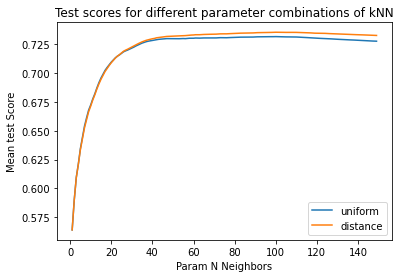

In [20]:
KNNuniform = KNN_results[(KNN_results['param_weights'] == 'uniform' )].sort_values(by = ['param_n_neighbors'])
KNNdistance = KNN_results[(KNN_results['param_weights'] == 'distance' )].sort_values(by = ['param_n_neighbors'])

plt.plot(KNNuniform['param_n_neighbors'], KNNuniform['mean_test_score'], label = 'uniform')
plt.plot(KNNdistance['param_n_neighbors'], KNNdistance['mean_test_score'], label = 'distance')

plt.xlabel('Param N Neighbors')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores for different parameter combinations of kNN')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

8.371646181516494


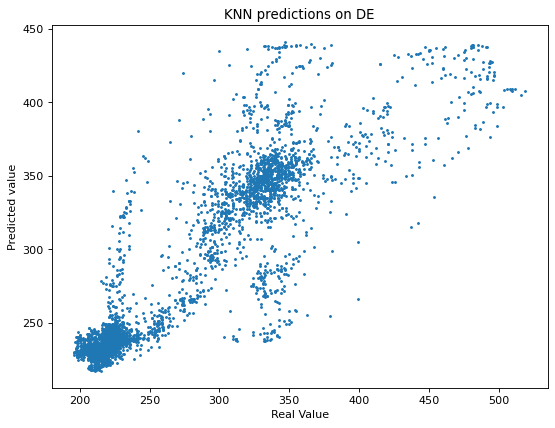

In [16]:
estimator = KNeighborsRegressor(n_neighbors = 100, weights = 'distance').fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

KNNMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(KNNMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('KNN predictions on DE')
# Display a figure.
plt.show()

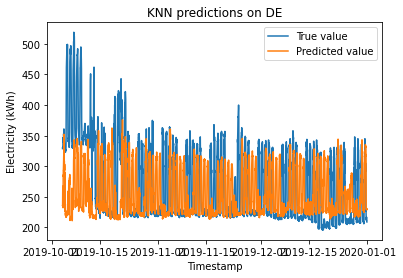

In [17]:
plt.title('KNN predictions on DE')
plt.plot(df['From Timestamp'].iloc[size:],validatey, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()


# SVM Regression

In [25]:
SVM = GridSearchCV(svm.SVR(gamma='scale'), {
    'C': [0.01, 0.1, 1, 100], 
    'kernel': ['rbf','linear'],
    'epsilon': [0.01,0.1,1,10]
}, cv=5, return_train_score=False, verbose = 4)
SVM.fit(inputXscaled, inputy)

svm_results = pd.DataFrame(SVM.cv_results_)
svmresults = svm_results[['param_kernel','param_C','param_epsilon', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
svmresults

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  31.2s
[CV 2/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  32.0s
[CV 3/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  31.4s
[CV 4/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  31.8s
[CV 5/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time=  31.0s
[CV 1/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  17.5s
[CV 2/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  16.7s
[CV 3/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  16.8s
[CV 4/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  17.7s
[CV 5/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  17.2s
[CV 1/5] END ................C=0.01, epsilon=0.1, kernel=rbf; total time=  31.0s
[CV 2/5] END ................C=0.01, epsilon=0.

[CV 2/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  29.3s
[CV 3/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  29.9s
[CV 4/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  29.3s
[CV 5/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  30.0s
[CV 1/5] END ..................C=1, epsilon=1, kernel=linear; total time=  17.8s
[CV 2/5] END ..................C=1, epsilon=1, kernel=linear; total time=  21.1s
[CV 3/5] END ..................C=1, epsilon=1, kernel=linear; total time=  18.1s
[CV 4/5] END ..................C=1, epsilon=1, kernel=linear; total time=  17.4s
[CV 5/5] END ..................C=1, epsilon=1, kernel=linear; total time=  17.3s
[CV 1/5] END ....................C=1, epsilon=10, kernel=rbf; total time=  17.0s
[CV 2/5] END ....................C=1, epsilon=10, kernel=rbf; total time=  16.4s
[CV 3/5] END ....................C=1, epsilon=10, kernel=rbf; total time=  15.8s
[CV 4/5] END ...............

,param_kernel,param_C,param_epsilon,mean_test_score,rank_test_score
28,rbf,100,1,0.774138,1
26,rbf,100,0.1,0.773795,2
24,rbf,100,0.01,0.773756,3
30,rbf,100,10,0.760757,4
16,rbf,1,0.01,0.740989,5
18,rbf,1,0.1,0.740983,6
20,rbf,1,1,0.740556,7
22,rbf,1,10,0.733426,8
7,linear,0.01,10,0.704492,9
1,linear,0.01,0.01,0.700026,10


5.653969740569823


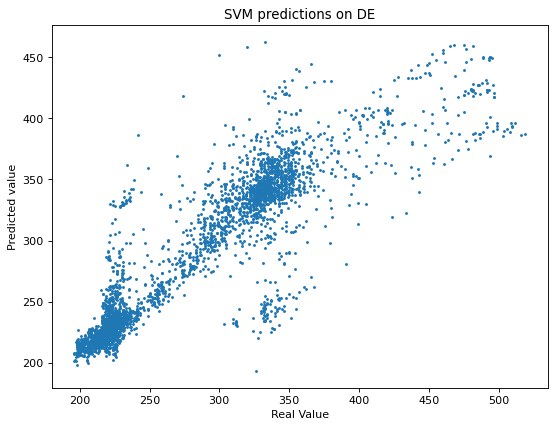

In [18]:
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X1scaled,y1,test_size=0.25,random_state=42) #split training:testing 75:25


estimator = svm.SVR(C = 100,  kernel = 'rbf', epsilon = 1).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

SVMMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions on DE')
# Display a figure.
plt.show()

5.653969740569823


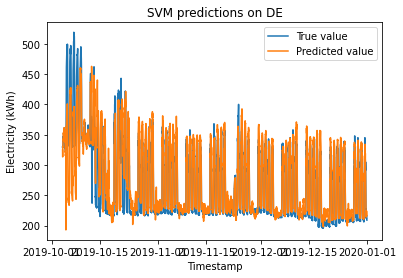

In [21]:
pred = estimator.predict(validateXscaled)

SVMMAPE = mean_absolute_percentage_error(validatey, pred) * 100
print(SVMMAPE)

plt.title('SVM predictions on DE')
plt.plot(df['From Timestamp'].iloc[size:],validatey, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()


# Inspecting/visualizing

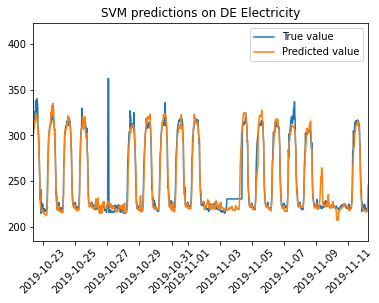

In [46]:
plt.title('SVM predictions on DE Electricity')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+2300], df['From Timestamp'].iloc[size+3300])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

#### First big spike is an outlier. Second strange shape is an entire missing day. I suspect the missing day caused the incorrect spike in the predictions on a weekend.

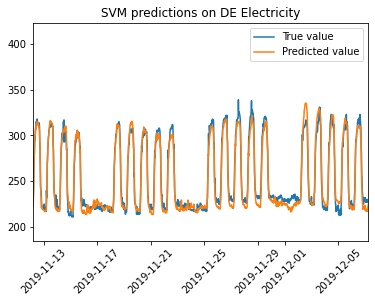

In [51]:
plt.title('SVM predictions on DE Electricity')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+3300], df['From Timestamp'].iloc[size+4500])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

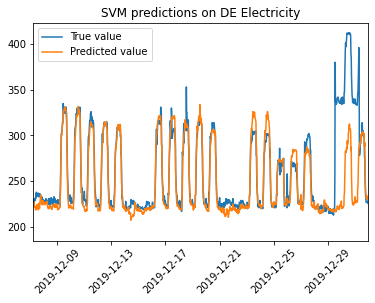

In [47]:
plt.title('SVM predictions on DE Electricity')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+4500], df['From Timestamp'].iloc[size+5688])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

# The next parts are used to find points of interest for 2.4 SHAP

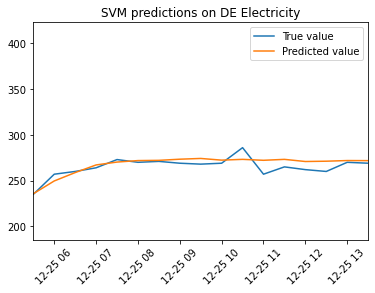

In [79]:
plt.title('SVM predictions on DE Electricity')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+5364], df['From Timestamp'].iloc[size+5380])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

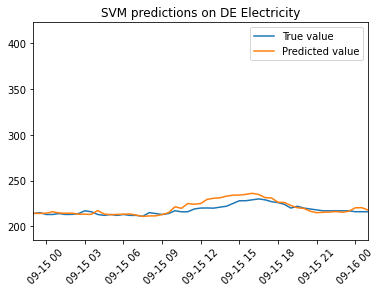

In [75]:
plt.title('SVM predictions on DE Electricity')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xlim(df['From Timestamp'].iloc[size+503], df['From Timestamp'].iloc[size+555])
plt.xticks(rotation=45)
# show a legend on the plot
plt.legend()

In [69]:
df[(df['Temperature (C)']==22.2) & (df['dayofweek']==6)]

,From Timestamp,DE Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
1169,2018-06-03 18:00:00,242.0,6,18.0,0,6,22.2,22.2,49.45,241.0,293.0,296.0,296.0,276.0,264.0,225.0
1170,2018-06-03 18:30:00,237.0,6,18.5,0,6,22.2,22.2,49.45,237.0,291.0,292.0,296.0,276.0,264.0,223.0
23677,2019-09-15 16:00:00,229.0,6,16.0,0,9,22.2,22.2,63.58,218.0,330.0,346.1,326.0,325.0,314.0,220.0
23678,2019-09-15 16:30:00,230.0,6,16.5,0,9,22.2,22.2,63.58,218.0,322.0,336.9,345.0,329.0,303.0,218.0


# Multilayer perceptron

In [28]:
from sklearn.neural_network import MLPRegressor

layers = range(1,30)

parameters = {'hidden_layer_sizes': layers, 'solver': ['lbfgs', 'adam'], 'max_iter': [3000], 'learning_rate_init': 10.0 ** -np.arange(1, 6, 2), 'random_state':[42]}
MLPReg = GridSearchCV(MLPRegressor(), parameters, cv=5,  verbose=2, return_train_score=False)
MLPReg.fit(inputXscaled, inputy)

MLPRegRes = pd.DataFrame(MLPReg.cv_results_)
MLP_results = MLPRegRes[['rank_test_score', 'mean_test_score', 'param_hidden_layer_sizes', 'param_solver', 'param_max_iter', 'param_learning_rate_init']].sort_values(by=['rank_test_score'])
MLP_results

Fitting 5 folds for each of 174 candidates, totalling 870 fits
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam;

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min
[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.9s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.1s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.7s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=2, learning_rate_

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.6s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.0s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.7s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=   9.6s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=   8.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.9min
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=   6.3s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=   8.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.0s
[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.6s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.4s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.6s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   0.3s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.2s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=3, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.1s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.8s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   1.2s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.2s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.2s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=4, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.6s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.0s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.6s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.4s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   2.6s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=5, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.4s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   8.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  10.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   0.7s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.6s
[CV] END hidden_layer_sizes=6, learning_rat

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  10.4s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.4s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  29.9s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  48.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  16.4s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  31.9s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.9s
[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   6.3s
[CV] END hidden_layer_sizes=6

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  10.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.9s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.2s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.4s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  10.3s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   4.7s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=7, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  14.0s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.2s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  28.3s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  42.3s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  20.8s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  36.5s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  48.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.9s
[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   3.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  13.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.7s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.5s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  11.7s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.4s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  15.7s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  11.0s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  29.7s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  40.8s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  33.2s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  24.9s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  51.5s
[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  12.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.3s
[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=   7.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.1s
[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  11.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.5s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.8s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.6s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  55.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  39.5s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.6s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.2s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.4s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  37.4s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  46.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  34.0s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  40.3s
[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.6s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.9s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  36.7s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  30.8s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  49.4s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  41.8s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  55.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  18.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.0s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.9s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  20.1s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  17.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  45.1s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  43.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  39.9s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  37.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  40.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.0s
[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  16.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  19.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.9s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  21.7s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  35.5s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  47.5s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  39.1s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  22.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  40.5s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  43.6s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  45.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  23.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  28.9s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  54.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  35.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  42.6s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  46.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  24.9s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  25.1s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  38.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  27.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  22.8s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  35.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  46.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  28.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.2s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.5s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  49.6s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  32.1s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  39.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  41.2s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  37.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  27.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  26.3s
[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.0s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.8s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  34.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  37.3s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  50.7s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  36.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  42.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.7s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   6.6s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.6s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  53.0s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.5min
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  31.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  32.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.0s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   7.2s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.1s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.4s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  54.4s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  38.9s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  56.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  33.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.0s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.9s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.2s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  30.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.6s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.3s
[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  29.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.0s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.5s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.3s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  42.0s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  48.4s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  43.3s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  45.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  46.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  34.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.8s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.7s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  55.1s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  42.0s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  57.9s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  35.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  36.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.3s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  37.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.2s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  53.7s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  54.1s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  59.6s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  55.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  38.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.3s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.3s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.1s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   6.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.2s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  54.6s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  48.6s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  52.8s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  58.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  39.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.1s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   8.3s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.1s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  52.7s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.2min
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  41.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.1s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   6.9s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   7.1s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   8.8s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.2s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  59.1s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  52.4s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  44.7s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  57.5s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  58.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  40.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  42.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.1s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=3000, random_state=42, solver=adam; total time=   1.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.2s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  53.1s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.4min
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.0min
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time=  56.7s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=3000, random_state=42, solver=adam; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  43.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=lbfgs; total time=  44.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=3000, random_state=42, solver=adam; total time= 2.3min


,rank_test_score,mean_test_score,param_hidden_layer_sizes,param_solver,param_max_iter,param_learning_rate_init
63,1,0.787944,11,adam,3000,0.001
22,2,0.782358,4,lbfgs,3000,0.00001
20,2,0.782358,4,lbfgs,3000,0.001
18,2,0.782358,4,lbfgs,3000,0.1
28,5,0.778818,5,lbfgs,3000,0.00001
...,...,...,...,...,...,...
23,170,-12.372802,4,adam,3000,0.00001
17,171,-12.395922,3,adam,3000,0.00001
41,172,-13.367193,7,adam,3000,0.00001
11,173,-18.476795,2,adam,3000,0.00001


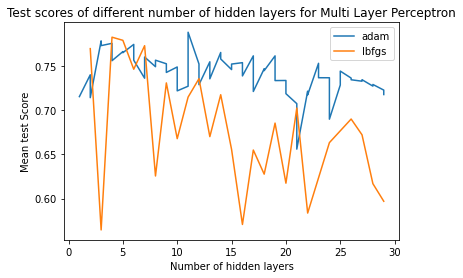

In [29]:
MLP_results1 = MLP_results[MLP_results['mean_test_score']>0.5]


MLP_adam = MLP_results1[(MLP_results1['param_solver'] == 'adam' )].sort_values(by = ['param_hidden_layer_sizes'])
MLP_lbfgs = MLP_results1[(MLP_results1['param_solver'] == 'lbfgs' )].sort_values(by = ['param_hidden_layer_sizes'])

plt.plot(MLP_adam['param_hidden_layer_sizes'], MLP_adam['mean_test_score'], label = 'adam')
plt.plot(MLP_lbfgs['param_hidden_layer_sizes'], MLP_lbfgs['mean_test_score'], label = 'lbfgs')

plt.xlabel('Number of hidden layers')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores of different number of hidden layers for Multi Layer Perceptron')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

6.21949471324435


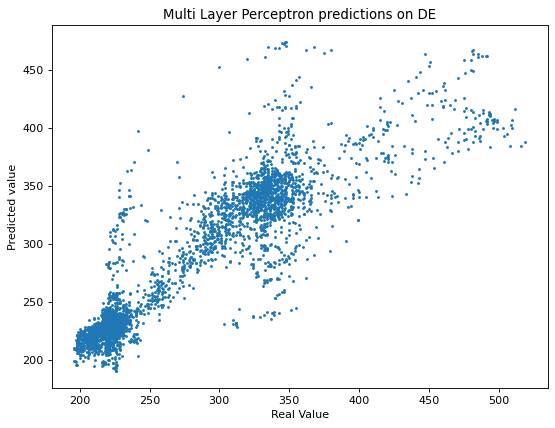

In [25]:
estimator = MLPRegressor(hidden_layer_sizes=11, solver = 'adam', max_iter=3000, learning_rate_init=0.001, random_state=42).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

MLPMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(MLPMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Multi Layer Perceptron predictions on DE')
# Display a figure.
plt.show()

6.2183405587744645


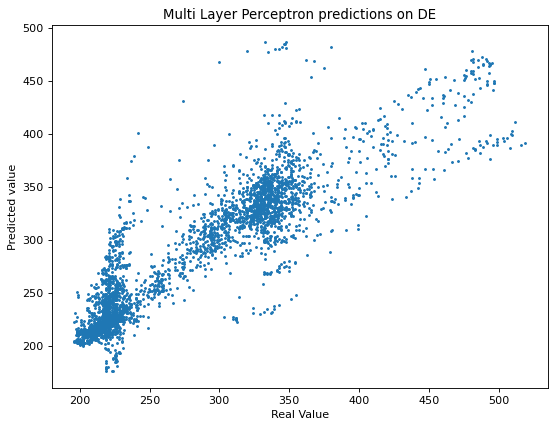

In [24]:
from sklearn.neural_network import MLPRegressor

estimator = MLPRegressor(hidden_layer_sizes=5, solver = 'adam', max_iter=3000, learning_rate_init=0.001, random_state=42).fit(trainXscaled, trainy)
y_pred = estimator.predict(validateXscaled)

MLPMAPE = mean_absolute_percentage_error(validatey, y_pred) * 100
print(MLPMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(validatey,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Multi Layer Perceptron predictions on DE')
# Display a figure.
plt.show()

3.597035476229746


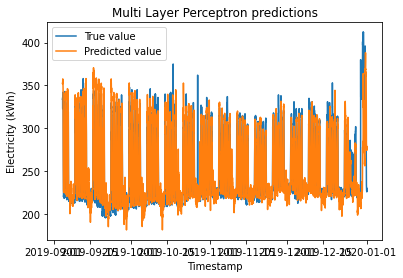

In [32]:
pred = estimator.predict(testXscaled)

MLPMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(MLPMAPE)

plt.title('Multi Layer Perceptron predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

# Random Split

In [28]:
df = pd.read_excel("BaseFeaturesDE.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['DE Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting
Y = df[['DE Electricity (kWh)']]


scaler = StandardScaler() #scaling
scaler.fit(X)
Xscaled = scaler.transform(X)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Xscaled,Y,test_size=0.20,random_state=42) #split training:testing 80:20


<ipython-input-45-9f1ddba3d58d>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator = RandomForestRegressor(n_estimators = 1500,  random_state=42).fit(X_train, y_train)


2.3077988182398763


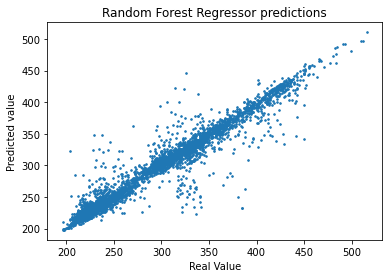

In [45]:
estimator = RandomForestRegressor(n_estimators = 1500,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

4.122870134444141


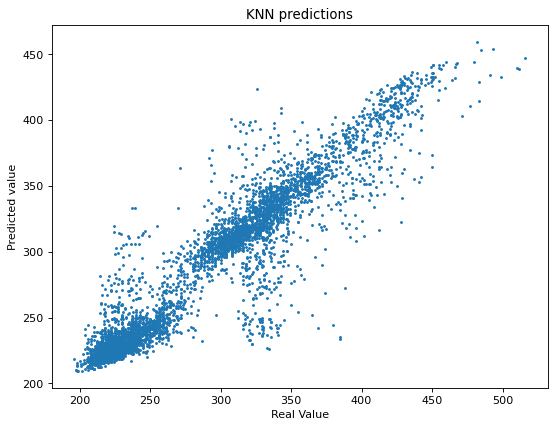

In [46]:
estimator = KNeighborsRegressor(n_neighbors = 100, weights = 'distance').fit(X_train, y_train)
y_pred = estimator.predict(X_test)

KNNMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(KNNMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('KNN predictions')
# Display a figure.
plt.show()

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2.8741178921857635


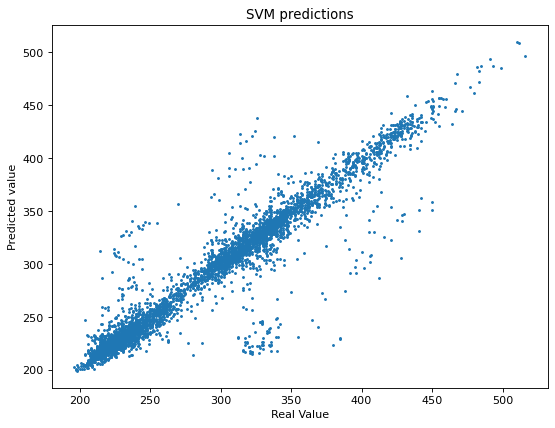

In [48]:
estimator = svm.SVR(C = 100,  kernel = 'rbf', epsilon = 0.001).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

SVMMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions')
# Display a figure.
plt.show()

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


4.99032176038922


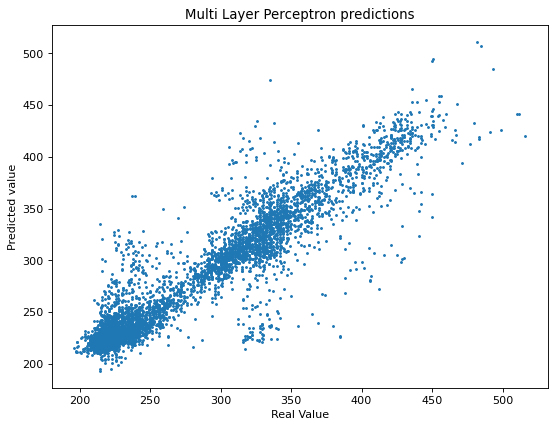

In [33]:
from sklearn.neural_network import MLPRegressor
estimator = MLPRegressor(hidden_layer_sizes=11, solver = 'lbfgs', max_iter=3000, learning_rate_init=0.001, random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

MLPMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(MLPMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Multi Layer Perceptron predictions')
# Display a figure.
plt.show()